## Imports and dataset loading

In [1]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

ampNumber   = 3
layerArray  = [2, 3, 4, 5, 6]
neuronArray = [32, 64, 128, 256, 512, 1024]
markers     = ["o", "^", "P", "s", "D", "x"]

trainErrors    = []
testGainArray  = []
testLossArray  = []
binaryDataSet  = []

originalDataSet = pd.read_csv('../datasets/4_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None)

for line in originalDataSet.values:
    myList = [1 if j != 0 else 0 for j in line[:40]]
    myList.extend(line[40:])
    binaryDataSet.append(myList)

binaryDataSet = pd.DataFrame(binaryDataSet)
gainScaler    = MinMaxScaler(feature_range = (-1, 1))
lossScaler    = MinMaxScaler(feature_range = (-1, 1))

gainScalerAux = []
lossScalerAux = []
    
for j in range(0, ampNumber * 2, 2):
    gainScalerAux.extend(binaryDataSet.values[:, 40 + j])
    lossScalerAux.extend(binaryDataSet.values[:, 40 + j + 1])

gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))

def loadDataset(): 
    dataSet = binaryDataSet.values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet.values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet.values[:, 40 + i + 1])
        loss    = lossScaler.transform(loss.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
            
    features, result = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    return features, result

def invertGainNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return gainScaler.inverse_transform(auxArray)[0][0]

def invertLossNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return lossScaler.inverse_transform(auxArray)[0][0]
    
def getGainError(value1, value2):
    return abs(invertGainNorm(value1) - invertGainNorm(value2))

def getLossError(value1, value2):
    return abs(invertLossNorm(value1) - invertLossNorm(value2))

## Train and validation functions

In [2]:
from sklearn.metrics import mean_absolute_error

def getTrainError(regressor, X, y):
    errors = []
    
    for i in range(30):
        history = regressor.fit(X, y, epochs = 50, verbose = False)
        errors.append(history.history["mean_squared_error"])
    
    return np.mean(errors)

def getTestErrors(regressor, X, y, folds = 5):
    foldSize       = math.ceil(X.shape[0] / folds)
    testGainErrors = []
    testLossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(X, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(y, np.s_[sliceBegin: sliceEnd], 0)
        X_test  = X[sliceBegin: sliceEnd]
        y_test  = y[sliceBegin: sliceEnd]

        regressor.fit(X_train, y_train)
        
        gainError  = 0
        lossError  = 0
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            for i in range(0, ampNumber * 2, 2):
                gainError += getGainError(predicted[i], expected[i]) 
                lossError += getLossError(predicted[i + 1], expected[i + 1])
                 
        testGainErrors.append((gainError / ampNumber) / foldSize)
        testLossErrors.append((lossError / ampNumber) / foldSize)
        
    return np.array(testGainErrors), np.array(testLossErrors)

In [3]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def trainModel(strategy):    
    features, result = loadDataset()
    trainError       = getTrainError(strategy, features, result)
    print(trainError)
    
    return trainError

def testModel(strategy):    
    features, result       = loadDataset()
    gainErrors, lossErrors = getTestErrors(strategy, features, result)
    
    print("Test errors")
    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(lossErrors), lossErrors.std() * 2))
    print()
    
    return np.mean(gainErrors), np.mean(lossErrors)

def setModel(layerNumber, neuronNumber):
    model = Sequential()
    
    if layerNumber == 2:
        model = keras.Sequential([
                    layers.Dense(neuronNumber, activation='relu', input_shape = [40]),
                    layers.Dense(neuronNumber, activation='relu'),
                    layers.Dense(2 * ampNumber)
                ])

    if layerNumber == 3:
        model = keras.Sequential([
                    layers.Dense(neuronNumber, activation='relu', input_shape = [40]),
                    layers.Dense(neuronNumber, activation='relu'),
                    layers.Dense(neuronNumber, activation='relu'),
                    layers.Dense(2 * ampNumber)
                ])
        
    if layerNumber == 4:
        model = keras.Sequential([
                    layers.Dense(neuronNumber, activation='relu', input_shape = [40]),
                    layers.Dense(neuronNumber, activation='relu'),
                    layers.Dense(neuronNumber, activation='relu'),
                    layers.Dense(neuronNumber, activation='relu'),
                    layers.Dense(2 * ampNumber)
                ])
        
    if layerNumber == 5:
        model = keras.Sequential([
                    layers.Dense(neuronNumber, activation='relu', input_shape = [40]),
                    layers.Dense(neuronNumber, activation='relu'),
                    layers.Dense(neuronNumber, activation='relu'),
                    layers.Dense(neuronNumber, activation='relu'),
                    layers.Dense(neuronNumber, activation='relu'),
                    layers.Dense(2 * ampNumber)
                ])
        
    if layerNumber == 6:
        model = keras.Sequential([
                    layers.Dense(neuronNumber, activation='relu', input_shape = [40]),
                    layers.Dense(neuronNumber, activation='relu'),
                    layers.Dense(neuronNumber, activation='relu'),
                    layers.Dense(neuronNumber, activation='relu'),
                    layers.Dense(neuronNumber, activation='relu'),
                    layers.Dense(neuronNumber, activation='relu'),
                    layers.Dense(2 * ampNumber)
                ])
    return model

Using TensorFlow backend.


## Plotting functions

In [4]:
def plotError():
    fig, axis = plt.subplots(figsize = (10, 5))

    for i in range(len(layerArray)):
        axis.plot(neuronArray, trainErrors[i])
        axis.scatter(neuronArray, trainErrors[i], marker = markers[i])
    
    axis.set_title("Train error for {} amplifiers".format(ampNumber))
    axis.set_xlabel("Neuron number")
    axis.set_ylabel("MSE (dB)")
    axis.legend(["{} hidden layers".format(x) for x in layerArray])

    plt.show()

def plotLossError():
    fig, axis = plt.subplots(figsize = (10, 5))

    for i in range(len(layerArray)):
        axis.plot(neuronArray, trainLossArray[i])
        axis.scatter(neuronArray, trainLossArray[i], marker = markers[i])
    
    axis.set_title("Loss error for {} amplifiers".format(ampNumber))
    axis.set_xlabel("Neuron number")
    axis.set_ylabel("MAE (dB)")
    axis.legend(["{} hidden layers".format(x) for x in layerArray])

    plt.show()

## Putting all together

In [5]:
for layerNumber in layerArray:
    print(layerNumber, "layers")
    trainErrors.append([])
    
    for neurons in neuronArray:
        model = setModel(layerNumber, neurons)
        model.compile(loss      = 'mse',
                      optimizer = "adam",
                      metrics   = ['mae', 'mse'])

        
        trainError = trainModel(model)
        trainErrors[-1].append(trainError)

print(trainErrors)

2 layers

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
0.09033949
0.09014447
0.09010491
0.09006291
0.09004769
0.09007063
3 layers
0.090294465
0.090119936
0.09003398
0.09002717
0.08999772
0.089985386
4 layers
0.09020355
0.090110995
0.090010844
0.09010031
0.09004897
0.090162955
5 layers
0.090253375
0.09010582
0.090104625
0.09003786
0.09063739
0.09076993
6 layers
0.09032343
0.09018148
0.09016502
0.09011682
0.09016987
0.09035231
[[0.09033949, 0.09014447, 0.09010491, 0.09006291, 0.09004769, 0.09007063], [0.090294465, 0.090119936, 0.09003398, 0.09002717, 0.08999772, 0.089985386], [0.09020355, 0.090110995, 0.090010844, 0.09010031, 0.09004897, 0.090162955], [0.090253375, 0.09010582, 0.090104625, 0.09003786, 0.09063739, 0.09076993], [0.09032343, 0.09018148, 0.09016502, 0.09011682, 0.09016987, 0.09035231]]


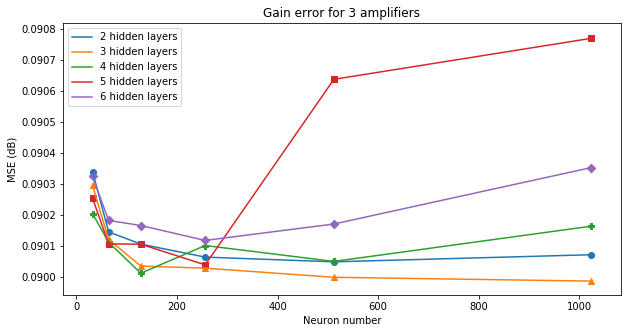

In [6]:
plotError()